In [1]:
from torchinfo import summary

C:\Users\sigma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cpu
torchvision version: 0.14.0+cpu


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# # Try to get torchinfo, install it if it doesn't work
# try:
#     from torchinfo import summary
# except:
#     print("[INFO] Couldn't find torchinfo... installing it.")
#     !pip install -q torchinfo
#     from torchinfo import summary

# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     from going_modular.going_modular import data_setup, engine
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [6]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc, precision, recall, score = 0, 0, 0, 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        precision = precision_score(y, y_pred_class, average='macro')
        recall = recall_score(y, y_pred_class, average='macro')
        score = f1_score(y, y_pred_class, average='weighted')

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    precision = precision / len(dataloader)
    recall = recall / len(dataloader)
    score = score / len(dataloader)

    return train_loss, train_acc, precision, recall, score

In [7]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [8]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "precision": [],
               "recall": [],
               "f1 score": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, precision, recall, score = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc, = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | ")
        print(
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"precision: {precision:.4f} | "
          f"recall: {recall:.4f} | "
          f"f1 score: {score:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["f1 score"].append(score)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [9]:
# ---------------------------------------- Data Setup file content-------------------------------

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):


  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


In [16]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder

image_path = Path("SegmentedDataset")

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

SegmentedDataset directory exists.


In [12]:
engine_file = ('/content/gdrive/MyDrive/Colab Notebooks/engine (edited).ipynb')

In [13]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [17]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2b186825810>,
 ['A001',
  'A002',
  'A003',
  'A004',
  'A005',
  'A005A',
  'A006',
  'A006A',
  'A006B',
  'A007',
  'A008',
  'A009',
  'A010',
  'A011',
  'A012',
  'A013',
  'A014',
  'A014A',
  'A015',
  'A016',
  'A017',
  'A017A',
  'A018',
  'A019',
  'A020',
  'A021',
  'A022',
  'A023',
  'A024',
  'A025',
  'A026',
  'A027',
  'A028',
  'A029',
  'A030',
  'A031',
  'A032',
  'A032A',
  'A033',
  'A034',
  'A035',
  'A036',
  'A037',
  'A038',
  'A039',
  'A040',
  'A040A',
  'A041',
  'A042',
  'A042A',
  'A043',
  'A043A',
  'A044',
  'A045',
  'A045A',
  'A046',
  'A047',
  'A048',
  'A049',
  'A050',
  'A051',
  'A052',
  'A053',
  'A054',
  'A055',
  'A056',
  'A057',
  'A058',
  'A059',
  'A060',
  'A061',
  'A062',
  'A063',
  'A064',
  'A065',
  'A066',
  'A067',
  'A068',
  'A069',
  'A070',
  'AA001',
  'AA002',
  'AA003',
  'AA004',
  'AA005',
  'AA006',
  'AA007',
  'AA007A',
  'AA007B',
  'AA008',
  'AA009',
  'AA01

In [18]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [19]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [20]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\sigma/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:07<00:00, 2.75MB/s]


In [21]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [22]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [23]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [24]:
#Taken from the finetune code starting from this cell

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [25]:
from torchvision import datasets, models, transforms

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    model_ft = models.efficientnet_b0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

In [26]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1072]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [27]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [29]:
# from going_modular.going_modular import data_setup, engine
import warnings
warnings.filterwarnings('ignore')
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
# print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
print('Total time taken is {:.0f}m {:.0f}s'.format(end_time-start_time // 60, end_time-start_time % 60))

  2%|▏         | 1/50 [49:01<40:01:58, 2941.20s/it]

Epoch: 1 | 
train_loss: 4.4906 | train_acc: 0.2570 | precision: 0.0000 | recall: 0.0000 | f1 score: 0.0000 | test_loss: 2.2206 | test_acc: 0.5904


  4%|▍         | 2/50 [1:38:13<39:18:15, 2947.82s/it]

Epoch: 2 | 
train_loss: 2.1517 | train_acc: 0.5977 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 1.4834 | test_acc: 0.6760


  6%|▌         | 3/50 [2:27:23<38:29:54, 2948.81s/it]

Epoch: 3 | 
train_loss: 1.5244 | train_acc: 0.6984 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 1.1430 | test_acc: 0.7262


  8%|▊         | 4/50 [3:16:43<37:43:58, 2953.00s/it]

Epoch: 4 | 
train_loss: 1.2140 | train_acc: 0.7526 | precision: 0.0000 | recall: 0.0000 | f1 score: 0.0000 | test_loss: 1.0401 | test_acc: 0.7462


 10%|█         | 5/50 [4:05:54<36:54:24, 2952.54s/it]

Epoch: 5 | 
train_loss: 1.0264 | train_acc: 0.7831 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.9454 | test_acc: 0.7542


 12%|█▏        | 6/50 [4:55:10<36:06:05, 2953.75s/it]

Epoch: 6 | 
train_loss: 0.8927 | train_acc: 0.8112 | precision: 0.0006 | recall: 0.0006 | f1 score: 0.0007 | test_loss: 0.8832 | test_acc: 0.7679


 14%|█▍        | 7/50 [5:44:24<35:16:42, 2953.56s/it]

Epoch: 7 | 
train_loss: 0.8316 | train_acc: 0.8215 | precision: 0.0000 | recall: 0.0000 | f1 score: 0.0000 | test_loss: 0.8408 | test_acc: 0.7723


 16%|█▌        | 8/50 [6:33:42<34:28:37, 2955.17s/it]

Epoch: 8 | 
train_loss: 0.7368 | train_acc: 0.8386 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.8544 | test_acc: 0.7681


 18%|█▊        | 9/50 [7:22:58<33:39:25, 2955.25s/it]

Epoch: 9 | 
train_loss: 0.6834 | train_acc: 0.8470 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.8010 | test_acc: 0.7790


 20%|██        | 10/50 [8:19:21<34:18:11, 3087.30s/it]

Epoch: 10 | 
train_loss: 0.6549 | train_acc: 0.8526 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.7868 | test_acc: 0.7847


 22%|██▏       | 11/50 [9:20:06<35:17:41, 3257.98s/it]

Epoch: 11 | 
train_loss: 0.6201 | train_acc: 0.8587 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.7856 | test_acc: 0.7834


 24%|██▍       | 12/50 [10:14:20<34:22:40, 3256.87s/it]

Epoch: 12 | 
train_loss: 0.5967 | train_acc: 0.8637 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7301 | test_acc: 0.7955


 26%|██▌       | 13/50 [11:03:38<32:32:39, 3166.47s/it]

Epoch: 13 | 
train_loss: 0.5632 | train_acc: 0.8705 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7737 | test_acc: 0.7835


 28%|██▊       | 14/50 [12:09:20<34:00:18, 3400.51s/it]

Epoch: 14 | 
train_loss: 0.5481 | train_acc: 0.8723 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7434 | test_acc: 0.7942


 30%|███       | 15/50 [13:18:01<35:10:17, 3617.65s/it]

Epoch: 15 | 
train_loss: 0.5278 | train_acc: 0.8786 | precision: 0.0006 | recall: 0.0006 | f1 score: 0.0007 | test_loss: 0.7296 | test_acc: 0.7952


 32%|███▏      | 16/50 [14:08:19<32:27:43, 3437.17s/it]

Epoch: 16 | 
train_loss: 0.5057 | train_acc: 0.8799 | precision: 0.0006 | recall: 0.0006 | f1 score: 0.0007 | test_loss: 0.6989 | test_acc: 0.8055


 34%|███▍      | 17/50 [14:58:35<30:20:54, 3310.74s/it]

Epoch: 17 | 
train_loss: 0.4964 | train_acc: 0.8836 | precision: 0.0006 | recall: 0.0006 | f1 score: 0.0007 | test_loss: 0.7052 | test_acc: 0.8030


 36%|███▌      | 18/50 [15:49:42<28:46:34, 3237.31s/it]

Epoch: 18 | 
train_loss: 0.4797 | train_acc: 0.8877 | precision: 0.0010 | recall: 0.0010 | f1 score: 0.0010 | test_loss: 0.7379 | test_acc: 0.7951


 38%|███▊      | 19/50 [16:40:47<27:25:58, 3185.77s/it]

Epoch: 19 | 
train_loss: 0.4839 | train_acc: 0.8852 | precision: 0.0000 | recall: 0.0000 | f1 score: 0.0000 | test_loss: 0.6946 | test_acc: 0.8033


 40%|████      | 20/50 [17:31:47<26:13:58, 3147.96s/it]

Epoch: 20 | 
train_loss: 0.4680 | train_acc: 0.8880 | precision: 0.0006 | recall: 0.0006 | f1 score: 0.0007 | test_loss: 0.7376 | test_acc: 0.7942


 42%|████▏     | 21/50 [18:22:48<25:08:56, 3121.93s/it]

Epoch: 21 | 
train_loss: 0.4530 | train_acc: 0.8921 | precision: 0.0006 | recall: 0.0006 | f1 score: 0.0007 | test_loss: 0.6951 | test_acc: 0.8065


 44%|████▍     | 22/50 [19:13:52<24:08:43, 3104.41s/it]

Epoch: 22 | 
train_loss: 0.4609 | train_acc: 0.8894 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.6882 | test_acc: 0.8064


 46%|████▌     | 23/50 [20:05:04<23:12:38, 3094.76s/it]

Epoch: 23 | 
train_loss: 0.4394 | train_acc: 0.8952 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7117 | test_acc: 0.8028


 48%|████▊     | 24/50 [20:56:09<22:17:10, 3085.77s/it]

Epoch: 24 | 
train_loss: 0.4327 | train_acc: 0.8970 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7027 | test_acc: 0.8037


 50%|█████     | 25/50 [21:47:15<21:23:15, 3079.83s/it]

Epoch: 25 | 
train_loss: 0.4410 | train_acc: 0.8948 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7034 | test_acc: 0.8070


 52%|█████▏    | 26/50 [22:38:20<20:30:07, 3075.33s/it]

Epoch: 26 | 
train_loss: 0.4293 | train_acc: 0.8962 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7091 | test_acc: 0.8027


 54%|█████▍    | 27/50 [23:29:25<19:37:43, 3072.31s/it]

Epoch: 27 | 
train_loss: 0.4282 | train_acc: 0.8961 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.6855 | test_acc: 0.8105


 56%|█████▌    | 28/50 [24:18:48<18:34:28, 3039.48s/it]

Epoch: 28 | 
train_loss: 0.4199 | train_acc: 0.8984 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.7328 | test_acc: 0.8005


 58%|█████▊    | 29/50 [25:06:28<17:24:58, 2985.64s/it]

Epoch: 29 | 
train_loss: 0.4193 | train_acc: 0.8996 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.7007 | test_acc: 0.8076


 60%|██████    | 30/50 [25:54:06<16:22:24, 2947.21s/it]

Epoch: 30 | 
train_loss: 0.4035 | train_acc: 0.9033 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.6768 | test_acc: 0.8113


 62%|██████▏   | 31/50 [26:41:42<15:24:40, 2920.04s/it]

Epoch: 31 | 
train_loss: 0.4166 | train_acc: 0.9004 | precision: 0.0010 | recall: 0.0010 | f1 score: 0.0010 | test_loss: 0.7223 | test_acc: 0.8062


 64%|██████▍   | 32/50 [27:29:23<14:30:42, 2902.35s/it]

Epoch: 32 | 
train_loss: 0.3874 | train_acc: 0.9053 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.7209 | test_acc: 0.8067


 66%|██████▌   | 33/50 [28:17:14<13:39:38, 2892.83s/it]

Epoch: 33 | 
train_loss: 0.3887 | train_acc: 0.9039 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.7063 | test_acc: 0.8081


 68%|██████▊   | 34/50 [29:04:55<12:48:51, 2883.20s/it]

Epoch: 34 | 
train_loss: 0.3987 | train_acc: 0.9040 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.6999 | test_acc: 0.8111


 70%|███████   | 35/50 [29:52:40<11:59:25, 2877.70s/it]

Epoch: 35 | 
train_loss: 0.3862 | train_acc: 0.9061 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7190 | test_acc: 0.8067


 72%|███████▏  | 36/50 [30:40:25<11:10:36, 2874.02s/it]

Epoch: 36 | 
train_loss: 0.3830 | train_acc: 0.9056 | precision: 0.0006 | recall: 0.0006 | f1 score: 0.0007 | test_loss: 0.6617 | test_acc: 0.8201


 74%|███████▍  | 37/50 [31:28:21<10:22:49, 2874.59s/it]

Epoch: 37 | 
train_loss: 0.3820 | train_acc: 0.9064 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.6935 | test_acc: 0.8106


 76%|███████▌  | 38/50 [32:16:04<9:34:13, 2871.12s/it] 

Epoch: 38 | 
train_loss: 0.3804 | train_acc: 0.9076 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.7010 | test_acc: 0.8118


 78%|███████▊  | 39/50 [33:08:09<9:00:19, 2947.22s/it]

Epoch: 39 | 
train_loss: 0.3937 | train_acc: 0.9032 | precision: 0.0000 | recall: 0.0000 | f1 score: 0.0000 | test_loss: 0.7152 | test_acc: 0.8087


 80%|████████  | 40/50 [34:01:20<8:23:25, 3020.55s/it]

Epoch: 40 | 
train_loss: 0.3876 | train_acc: 0.9071 | precision: 0.0000 | recall: 0.0000 | f1 score: 0.0000 | test_loss: 0.7045 | test_acc: 0.8085


 82%|████████▏ | 41/50 [34:55:59<7:44:41, 3097.96s/it]

Epoch: 41 | 
train_loss: 0.3826 | train_acc: 0.9070 | precision: 0.0006 | recall: 0.0006 | f1 score: 0.0007 | test_loss: 0.6841 | test_acc: 0.8142


 84%|████████▍ | 42/50 [35:51:33<7:02:30, 3168.83s/it]

Epoch: 42 | 
train_loss: 0.3849 | train_acc: 0.9072 | precision: 0.0006 | recall: 0.0006 | f1 score: 0.0007 | test_loss: 0.7267 | test_acc: 0.8083


 86%|████████▌ | 43/50 [36:47:44<6:16:45, 3229.32s/it]

Epoch: 43 | 
train_loss: 0.3734 | train_acc: 0.9082 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.6654 | test_acc: 0.8208


 88%|████████▊ | 44/50 [37:48:17<5:35:03, 3350.59s/it]

Epoch: 44 | 
train_loss: 0.3599 | train_acc: 0.9105 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7206 | test_acc: 0.8112


 90%|█████████ | 45/50 [38:42:16<4:36:25, 3317.16s/it]

Epoch: 45 | 
train_loss: 0.3685 | train_acc: 0.9102 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.6796 | test_acc: 0.8183


 92%|█████████▏| 46/50 [39:32:48<3:35:25, 3231.41s/it]

Epoch: 46 | 
train_loss: 0.3740 | train_acc: 0.9111 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.7213 | test_acc: 0.8095


 94%|█████████▍| 47/50 [40:21:08<2:36:36, 3132.09s/it]

Epoch: 47 | 
train_loss: 0.3656 | train_acc: 0.9099 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.7201 | test_acc: 0.8122


 96%|█████████▌| 48/50 [41:09:58<1:42:23, 3071.58s/it]

Epoch: 48 | 
train_loss: 0.3652 | train_acc: 0.9100 | precision: 0.0001 | recall: 0.0001 | f1 score: 0.0002 | test_loss: 0.7027 | test_acc: 0.8126


 98%|█████████▊| 49/50 [42:00:46<51:04, 3064.44s/it]  

Epoch: 49 | 
train_loss: 0.3664 | train_acc: 0.9112 | precision: 0.0003 | recall: 0.0003 | f1 score: 0.0005 | test_loss: 0.6817 | test_acc: 0.8175


100%|██████████| 50/50 [42:51:31<00:00, 3085.83s/it]

Epoch: 50 | 
train_loss: 0.3668 | train_acc: 0.9093 | precision: 0.0000 | recall: 0.0000 | f1 score: 0.0000 | test_loss: 0.7525 | test_acc: 0.8067
Total time taken is 385848m 389732s


In [32]:
# --------------------------------------------------------- Coode inside train_step function ---------------------------------------------------------

model.train()

# Setup train loss and train accuracy values
train_loss, train_acc = 0, 0

y = []
y_pred = []

# Loop through data loader data batches
for batch, (X, y) in enumerate(train_dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate  and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

# Adjust metrics to get average loss and accuracy per batch
train_loss = train_loss / len(train_dataloader)
train_acc = train_acc / len(train_dataloader)

print("y: ",y)
print("y_pred: ", y_pred_class)

y:  tensor([1023,  852,  474,  265])
y_pred:  tensor([121, 852, 474, 839])


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (2).

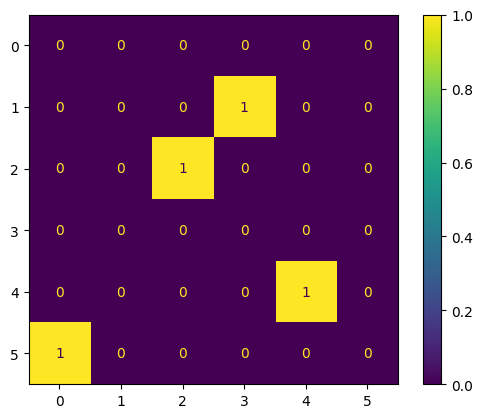

In [38]:
confusion_matrix = metrics.confusion_matrix(y, y_pred_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

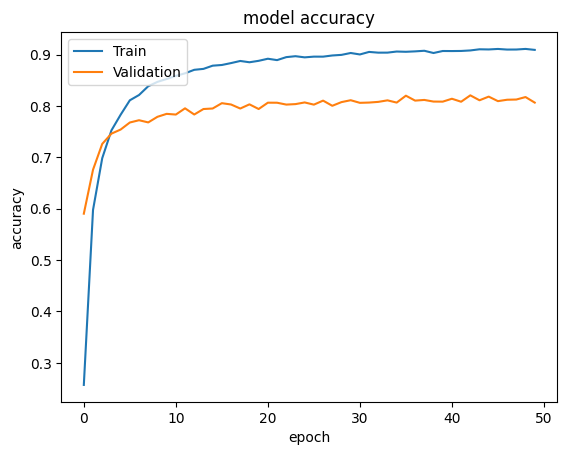

In [34]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(results['train_acc'])
plt.plot(results['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

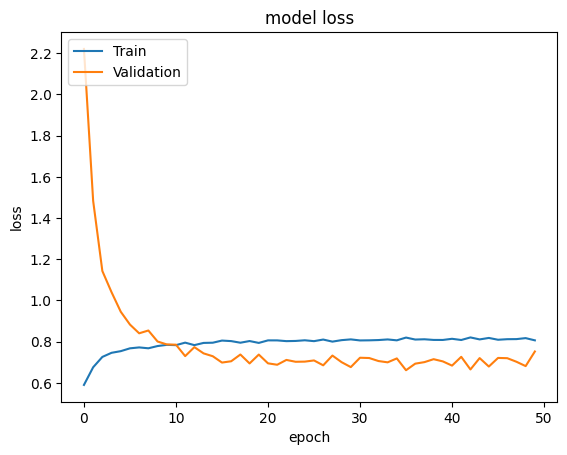

In [35]:
# summarize history for loss
plt.plot(results['test_acc'])
plt.plot(results['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
results.save(model.state_dict(), data_path)

AttributeError: 'dict' object has no attribute 'save'